<a href="https://colab.research.google.com/github/avirooppal/FusionLite-CNN-Lightweight-Deep-Learning-for-Real-Time-Crop-Drought-Detection-on-Edge/blob/main/fusion_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

=== ENHANCED CROP HEALTH CLASSIFICATION SYSTEM ===
Initializing enhanced dataset...
Dataset size: 3000
Classes: ['healthy', 'mild_stress', 'moderate_stress', 'severe_stress', 'drought']

Analyzing data distribution...


OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

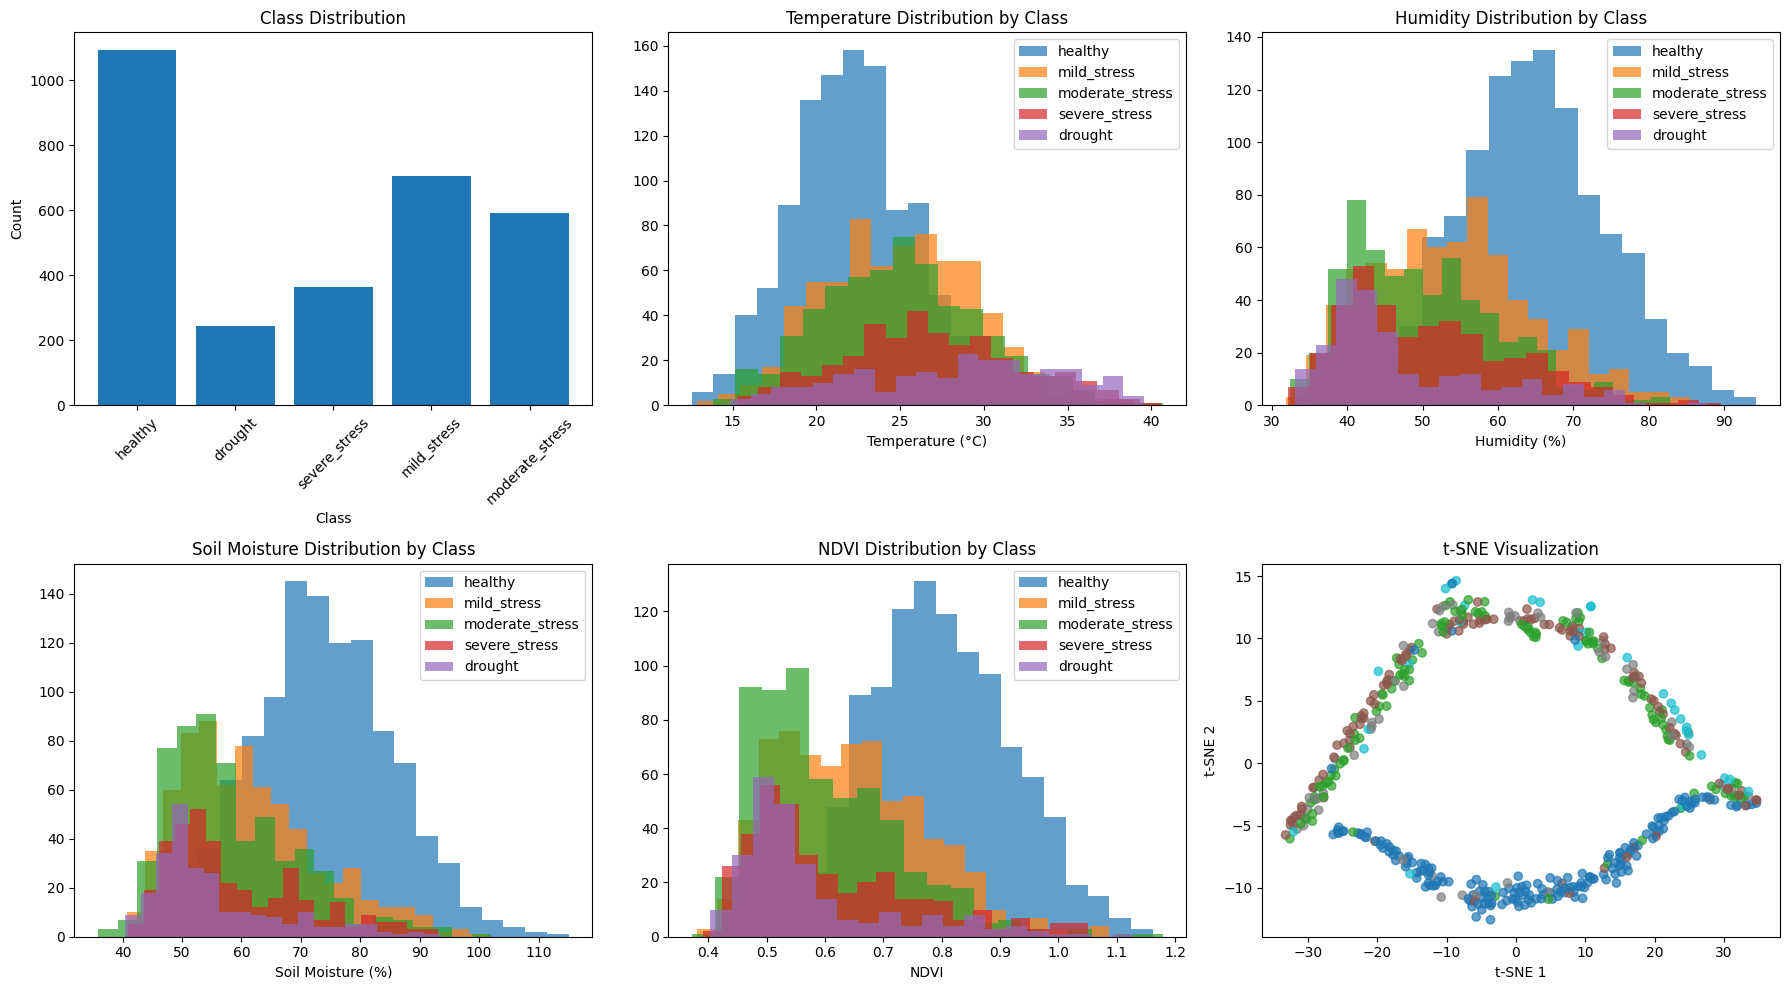

Creating train/validation/test splits...
Train: 1800, Val: 600, Test: 600

Initializing advanced model...
Model parameters: 1,808,712

Training model...
Training on device: cuda


Epoch 1/50: 100%|██████████| 57/57 [00:02<00:00, 23.78it/s, Loss=0.8598, Acc=0.748]


Epoch 1: Train Loss: 0.5838, Val Loss: 0.4772
Train Acc: 0.748, Val Acc: 0.852
Train F1: 0.746, Val F1: 0.850, LR: 0.000999
------------------------------------------------------------


Epoch 2/50: 100%|██████████| 57/57 [00:02<00:00, 24.79it/s, Loss=0.5121, Acc=0.786]


Epoch 2: Train Loss: 0.5272, Val Loss: 0.4792
Train Acc: 0.786, Val Acc: 0.852
Train F1: 0.783, Val F1: 0.850, LR: 0.000996
------------------------------------------------------------


Epoch 3/50: 100%|██████████| 57/57 [00:02<00:00, 24.89it/s, Loss=0.2318, Acc=0.777]


Epoch 3: Train Loss: 0.5165, Val Loss: 0.5039
Train Acc: 0.777, Val Acc: 0.845
Train F1: 0.775, Val F1: 0.843, LR: 0.000991
------------------------------------------------------------


Epoch 4/50: 100%|██████████| 57/57 [00:02<00:00, 24.06it/s, Loss=0.9483, Acc=0.784]


Epoch 4: Train Loss: 0.5075, Val Loss: 0.5791
Train Acc: 0.784, Val Acc: 0.852
Train F1: 0.781, Val F1: 0.850, LR: 0.000984
------------------------------------------------------------


Epoch 5/50: 100%|██████████| 57/57 [00:02<00:00, 24.90it/s, Loss=0.3797, Acc=0.781]


Epoch 5: Train Loss: 0.5250, Val Loss: 0.4550
Train Acc: 0.781, Val Acc: 0.852
Train F1: 0.779, Val F1: 0.850, LR: 0.000976
------------------------------------------------------------


Epoch 6/50: 100%|██████████| 57/57 [00:02<00:00, 25.03it/s, Loss=0.3383, Acc=0.786]


Epoch 6: Train Loss: 0.5151, Val Loss: 0.4760
Train Acc: 0.786, Val Acc: 0.850
Train F1: 0.785, Val F1: 0.848, LR: 0.000965
------------------------------------------------------------


Epoch 7/50: 100%|██████████| 57/57 [00:02<00:00, 24.50it/s, Loss=0.6393, Acc=0.802]


Epoch 7: Train Loss: 0.4861, Val Loss: 0.4631
Train Acc: 0.802, Val Acc: 0.850
Train F1: 0.800, Val F1: 0.848, LR: 0.000952
------------------------------------------------------------


Epoch 8/50: 100%|██████████| 57/57 [00:02<00:00, 25.33it/s, Loss=0.6661, Acc=0.786]


Epoch 8: Train Loss: 0.5100, Val Loss: 0.4725
Train Acc: 0.786, Val Acc: 0.848
Train F1: 0.783, Val F1: 0.846, LR: 0.000938
------------------------------------------------------------


Epoch 9/50: 100%|██████████| 57/57 [00:02<00:00, 24.73it/s, Loss=0.1720, Acc=0.779]


Epoch 9: Train Loss: 0.5120, Val Loss: 0.4787
Train Acc: 0.779, Val Acc: 0.852
Train F1: 0.776, Val F1: 0.850, LR: 0.000922
------------------------------------------------------------


Epoch 10/50: 100%|██████████| 57/57 [00:02<00:00, 25.02it/s, Loss=0.4790, Acc=0.773]


Epoch 10: Train Loss: 0.5453, Val Loss: 0.4598
Train Acc: 0.773, Val Acc: 0.852
Train F1: 0.768, Val F1: 0.850, LR: 0.000905
------------------------------------------------------------


Epoch 11/50: 100%|██████████| 57/57 [00:02<00:00, 24.29it/s, Loss=0.3993, Acc=0.778]


Epoch 11: Train Loss: 0.4984, Val Loss: 0.4636
Train Acc: 0.778, Val Acc: 0.852
Train F1: 0.774, Val F1: 0.850, LR: 0.000885
------------------------------------------------------------


Epoch 12/50: 100%|██████████| 57/57 [00:02<00:00, 24.71it/s, Loss=0.7733, Acc=0.786]


Epoch 12: Train Loss: 0.4966, Val Loss: 0.5080
Train Acc: 0.786, Val Acc: 0.852
Train F1: 0.782, Val F1: 0.850, LR: 0.000865
------------------------------------------------------------


Epoch 13/50: 100%|██████████| 57/57 [00:02<00:00, 24.95it/s, Loss=0.9143, Acc=0.791]


Epoch 13: Train Loss: 0.5012, Val Loss: 0.4597
Train Acc: 0.791, Val Acc: 0.852
Train F1: 0.788, Val F1: 0.850, LR: 0.000842
------------------------------------------------------------


Epoch 14/50: 100%|██████████| 57/57 [00:02<00:00, 24.17it/s, Loss=0.9222, Acc=0.806]


Epoch 14: Train Loss: 0.4684, Val Loss: 0.4850
Train Acc: 0.806, Val Acc: 0.852
Train F1: 0.802, Val F1: 0.850, LR: 0.000819
------------------------------------------------------------


Epoch 15/50: 100%|██████████| 57/57 [00:02<00:00, 23.62it/s, Loss=0.6364, Acc=0.808]


Epoch 15: Train Loss: 0.4712, Val Loss: 0.4536
Train Acc: 0.808, Val Acc: 0.852
Train F1: 0.806, Val F1: 0.850, LR: 0.000794
------------------------------------------------------------


Epoch 16/50: 100%|██████████| 57/57 [00:02<00:00, 24.42it/s, Loss=0.4609, Acc=0.786]


Epoch 16: Train Loss: 0.4980, Val Loss: 0.5117
Train Acc: 0.786, Val Acc: 0.852
Train F1: 0.784, Val F1: 0.850, LR: 0.000768
------------------------------------------------------------


Epoch 17/50: 100%|██████████| 57/57 [00:02<00:00, 24.50it/s, Loss=0.6123, Acc=0.777]


Epoch 17: Train Loss: 0.5280, Val Loss: 0.4791
Train Acc: 0.777, Val Acc: 0.852
Train F1: 0.773, Val F1: 0.850, LR: 0.000741
------------------------------------------------------------


Epoch 18/50: 100%|██████████| 57/57 [00:02<00:00, 24.51it/s, Loss=0.9204, Acc=0.791]


Epoch 18: Train Loss: 0.5048, Val Loss: 0.4644
Train Acc: 0.791, Val Acc: 0.852
Train F1: 0.789, Val F1: 0.850, LR: 0.000713
------------------------------------------------------------


Epoch 19/50: 100%|██████████| 57/57 [00:02<00:00, 24.88it/s, Loss=0.6933, Acc=0.814]


Epoch 19: Train Loss: 0.4484, Val Loss: 0.4823
Train Acc: 0.814, Val Acc: 0.852
Train F1: 0.812, Val F1: 0.850, LR: 0.000684
------------------------------------------------------------


Epoch 20/50: 100%|██████████| 57/57 [00:02<00:00, 24.86it/s, Loss=0.6290, Acc=0.788]


Epoch 20: Train Loss: 0.4955, Val Loss: 0.4520
Train Acc: 0.788, Val Acc: 0.852
Train F1: 0.786, Val F1: 0.850, LR: 0.000655
------------------------------------------------------------


Epoch 21/50: 100%|██████████| 57/57 [00:02<00:00, 24.87it/s, Loss=0.4940, Acc=0.813]


Epoch 21: Train Loss: 0.4621, Val Loss: 0.4580
Train Acc: 0.813, Val Acc: 0.852
Train F1: 0.811, Val F1: 0.850, LR: 0.000625
------------------------------------------------------------


Epoch 22/50: 100%|██████████| 57/57 [00:02<00:00, 24.75it/s, Loss=0.5019, Acc=0.789]


Epoch 22: Train Loss: 0.5018, Val Loss: 0.4391
Train Acc: 0.789, Val Acc: 0.852
Train F1: 0.785, Val F1: 0.850, LR: 0.000594
------------------------------------------------------------


Epoch 23/50: 100%|██████████| 57/57 [00:02<00:00, 24.84it/s, Loss=0.5815, Acc=0.789]


Epoch 23: Train Loss: 0.4790, Val Loss: 0.4643
Train Acc: 0.789, Val Acc: 0.852
Train F1: 0.785, Val F1: 0.850, LR: 0.000563
------------------------------------------------------------


Epoch 24/50: 100%|██████████| 57/57 [00:02<00:00, 24.90it/s, Loss=0.6844, Acc=0.804]


Epoch 24: Train Loss: 0.4551, Val Loss: 0.4718
Train Acc: 0.804, Val Acc: 0.852
Train F1: 0.802, Val F1: 0.850, LR: 0.000532
------------------------------------------------------------


Epoch 25/50: 100%|██████████| 57/57 [00:02<00:00, 24.07it/s, Loss=0.1235, Acc=0.812]


Epoch 25: Train Loss: 0.4334, Val Loss: 0.4680
Train Acc: 0.812, Val Acc: 0.852
Train F1: 0.809, Val F1: 0.850, LR: 0.000500
------------------------------------------------------------


Epoch 26/50: 100%|██████████| 57/57 [00:02<00:00, 24.30it/s, Loss=1.0247, Acc=0.781]


Epoch 26: Train Loss: 0.5016, Val Loss: 0.4777
Train Acc: 0.781, Val Acc: 0.852
Train F1: 0.778, Val F1: 0.850, LR: 0.000469
------------------------------------------------------------


Epoch 27/50: 100%|██████████| 57/57 [00:02<00:00, 24.90it/s, Loss=0.3656, Acc=0.786]


Epoch 27: Train Loss: 0.4729, Val Loss: 0.4837
Train Acc: 0.786, Val Acc: 0.852
Train F1: 0.784, Val F1: 0.850, LR: 0.000438
------------------------------------------------------------


Epoch 28/50: 100%|██████████| 57/57 [00:02<00:00, 24.74it/s, Loss=0.5786, Acc=0.800]


Epoch 28: Train Loss: 0.4758, Val Loss: 0.4627
Train Acc: 0.800, Val Acc: 0.852
Train F1: 0.798, Val F1: 0.850, LR: 0.000407
------------------------------------------------------------


Epoch 29/50: 100%|██████████| 57/57 [00:02<00:00, 24.78it/s, Loss=0.5510, Acc=0.765]


Epoch 29: Train Loss: 0.5384, Val Loss: 0.4699
Train Acc: 0.765, Val Acc: 0.852
Train F1: 0.761, Val F1: 0.850, LR: 0.000376
------------------------------------------------------------


Epoch 30/50: 100%|██████████| 57/57 [00:02<00:00, 24.92it/s, Loss=0.5634, Acc=0.793]


Epoch 30: Train Loss: 0.4687, Val Loss: 0.4839
Train Acc: 0.793, Val Acc: 0.852
Train F1: 0.789, Val F1: 0.850, LR: 0.000346
------------------------------------------------------------


Epoch 31/50: 100%|██████████| 57/57 [00:02<00:00, 24.97it/s, Loss=1.2737, Acc=0.783]


Epoch 31: Train Loss: 0.5100, Val Loss: 0.4879
Train Acc: 0.783, Val Acc: 0.852
Train F1: 0.780, Val F1: 0.850, LR: 0.000317
------------------------------------------------------------


Epoch 32/50: 100%|██████████| 57/57 [00:02<00:00, 24.54it/s, Loss=0.6961, Acc=0.798]


Epoch 32: Train Loss: 0.4530, Val Loss: 0.4667
Train Acc: 0.798, Val Acc: 0.852
Train F1: 0.796, Val F1: 0.850, LR: 0.000288
------------------------------------------------------------


Epoch 33/50: 100%|██████████| 57/57 [00:02<00:00, 24.86it/s, Loss=0.2693, Acc=0.801]


Epoch 33: Train Loss: 0.4534, Val Loss: 0.4576
Train Acc: 0.801, Val Acc: 0.852
Train F1: 0.797, Val F1: 0.850, LR: 0.000260
------------------------------------------------------------


Epoch 34/50: 100%|██████████| 57/57 [00:02<00:00, 24.63it/s, Loss=0.3869, Acc=0.803]


Epoch 34: Train Loss: 0.4557, Val Loss: 0.4529
Train Acc: 0.803, Val Acc: 0.852
Train F1: 0.799, Val F1: 0.850, LR: 0.000233
------------------------------------------------------------


Epoch 35/50: 100%|██████████| 57/57 [00:02<00:00, 24.98it/s, Loss=0.1346, Acc=0.806]


Epoch 35: Train Loss: 0.4438, Val Loss: 0.4515
Train Acc: 0.806, Val Acc: 0.852
Train F1: 0.803, Val F1: 0.850, LR: 0.000207
------------------------------------------------------------


Epoch 36/50: 100%|██████████| 57/57 [00:02<00:00, 24.66it/s, Loss=0.8223, Acc=0.786]


Epoch 36: Train Loss: 0.4810, Val Loss: 0.4654
Train Acc: 0.786, Val Acc: 0.852
Train F1: 0.782, Val F1: 0.850, LR: 0.000182
------------------------------------------------------------


Epoch 37/50: 100%|██████████| 57/57 [00:02<00:00, 24.70it/s, Loss=0.6056, Acc=0.797]


Epoch 37: Train Loss: 0.4484, Val Loss: 0.4731
Train Acc: 0.797, Val Acc: 0.852
Train F1: 0.794, Val F1: 0.850, LR: 0.000159
------------------------------------------------------------


Epoch 38/50: 100%|██████████| 57/57 [00:02<00:00, 24.54it/s, Loss=0.1115, Acc=0.797]


Epoch 38: Train Loss: 0.4529, Val Loss: 0.4731
Train Acc: 0.797, Val Acc: 0.852
Train F1: 0.794, Val F1: 0.850, LR: 0.000136
------------------------------------------------------------


Epoch 39/50: 100%|██████████| 57/57 [00:02<00:00, 24.90it/s, Loss=0.1336, Acc=0.795]


Epoch 39: Train Loss: 0.4615, Val Loss: 0.4656
Train Acc: 0.795, Val Acc: 0.852
Train F1: 0.790, Val F1: 0.850, LR: 0.000116
------------------------------------------------------------


Epoch 40/50: 100%|██████████| 57/57 [00:02<00:00, 24.90it/s, Loss=0.6107, Acc=0.792]


Epoch 40: Train Loss: 0.4741, Val Loss: 0.4681
Train Acc: 0.792, Val Acc: 0.852
Train F1: 0.788, Val F1: 0.850, LR: 0.000096
------------------------------------------------------------


Epoch 41/50: 100%|██████████| 57/57 [00:02<00:00, 25.12it/s, Loss=0.4995, Acc=0.785]


Epoch 41: Train Loss: 0.4765, Val Loss: 0.4590
Train Acc: 0.785, Val Acc: 0.852
Train F1: 0.781, Val F1: 0.850, LR: 0.000079
------------------------------------------------------------


Epoch 42/50: 100%|██████████| 57/57 [00:02<00:00, 24.86it/s, Loss=0.3851, Acc=0.783]


Epoch 42: Train Loss: 0.4838, Val Loss: 0.4676
Train Acc: 0.783, Val Acc: 0.852
Train F1: 0.782, Val F1: 0.850, LR: 0.000063
------------------------------------------------------------


Epoch 43/50: 100%|██████████| 57/57 [00:02<00:00, 25.04it/s, Loss=0.1558, Acc=0.796]


Epoch 43: Train Loss: 0.4586, Val Loss: 0.4757
Train Acc: 0.796, Val Acc: 0.852
Train F1: 0.793, Val F1: 0.850, LR: 0.000049
------------------------------------------------------------


Epoch 44/50: 100%|██████████| 57/57 [00:02<00:00, 24.96it/s, Loss=0.2917, Acc=0.786]


Epoch 44: Train Loss: 0.4811, Val Loss: 0.4659
Train Acc: 0.786, Val Acc: 0.852
Train F1: 0.782, Val F1: 0.850, LR: 0.000036
------------------------------------------------------------


Epoch 45/50: 100%|██████████| 57/57 [00:02<00:00, 24.28it/s, Loss=0.5142, Acc=0.792]


Epoch 45: Train Loss: 0.4826, Val Loss: 0.4566
Train Acc: 0.792, Val Acc: 0.852
Train F1: 0.792, Val F1: 0.850, LR: 0.000025
------------------------------------------------------------


Epoch 46/50: 100%|██████████| 57/57 [00:02<00:00, 24.65it/s, Loss=0.7940, Acc=0.796]


Epoch 46: Train Loss: 0.4578, Val Loss: 0.4651
Train Acc: 0.796, Val Acc: 0.852
Train F1: 0.794, Val F1: 0.850, LR: 0.000017
------------------------------------------------------------


Epoch 47/50: 100%|██████████| 57/57 [00:02<00:00, 24.62it/s, Loss=0.3138, Acc=0.802]


Epoch 47: Train Loss: 0.4552, Val Loss: 0.4587
Train Acc: 0.802, Val Acc: 0.852
Train F1: 0.800, Val F1: 0.850, LR: 0.000010
------------------------------------------------------------


Epoch 48/50: 100%|██████████| 57/57 [00:02<00:00, 25.03it/s, Loss=0.1300, Acc=0.811]


Epoch 48: Train Loss: 0.4420, Val Loss: 0.4578
Train Acc: 0.811, Val Acc: 0.852
Train F1: 0.809, Val F1: 0.850, LR: 0.000005
------------------------------------------------------------


Epoch 49/50: 100%|██████████| 57/57 [00:02<00:00, 23.87it/s, Loss=0.2502, Acc=0.790]


Epoch 49: Train Loss: 0.4575, Val Loss: 0.4655
Train Acc: 0.790, Val Acc: 0.852
Train F1: 0.787, Val F1: 0.850, LR: 0.000002
------------------------------------------------------------


Epoch 50/50: 100%|██████████| 57/57 [00:02<00:00, 24.89it/s, Loss=0.6383, Acc=0.789]


Epoch 50: Train Loss: 0.4694, Val Loss: 0.4583
Train Acc: 0.789, Val Acc: 0.852
Train F1: 0.786, Val F1: 0.850, LR: 0.000001
------------------------------------------------------------


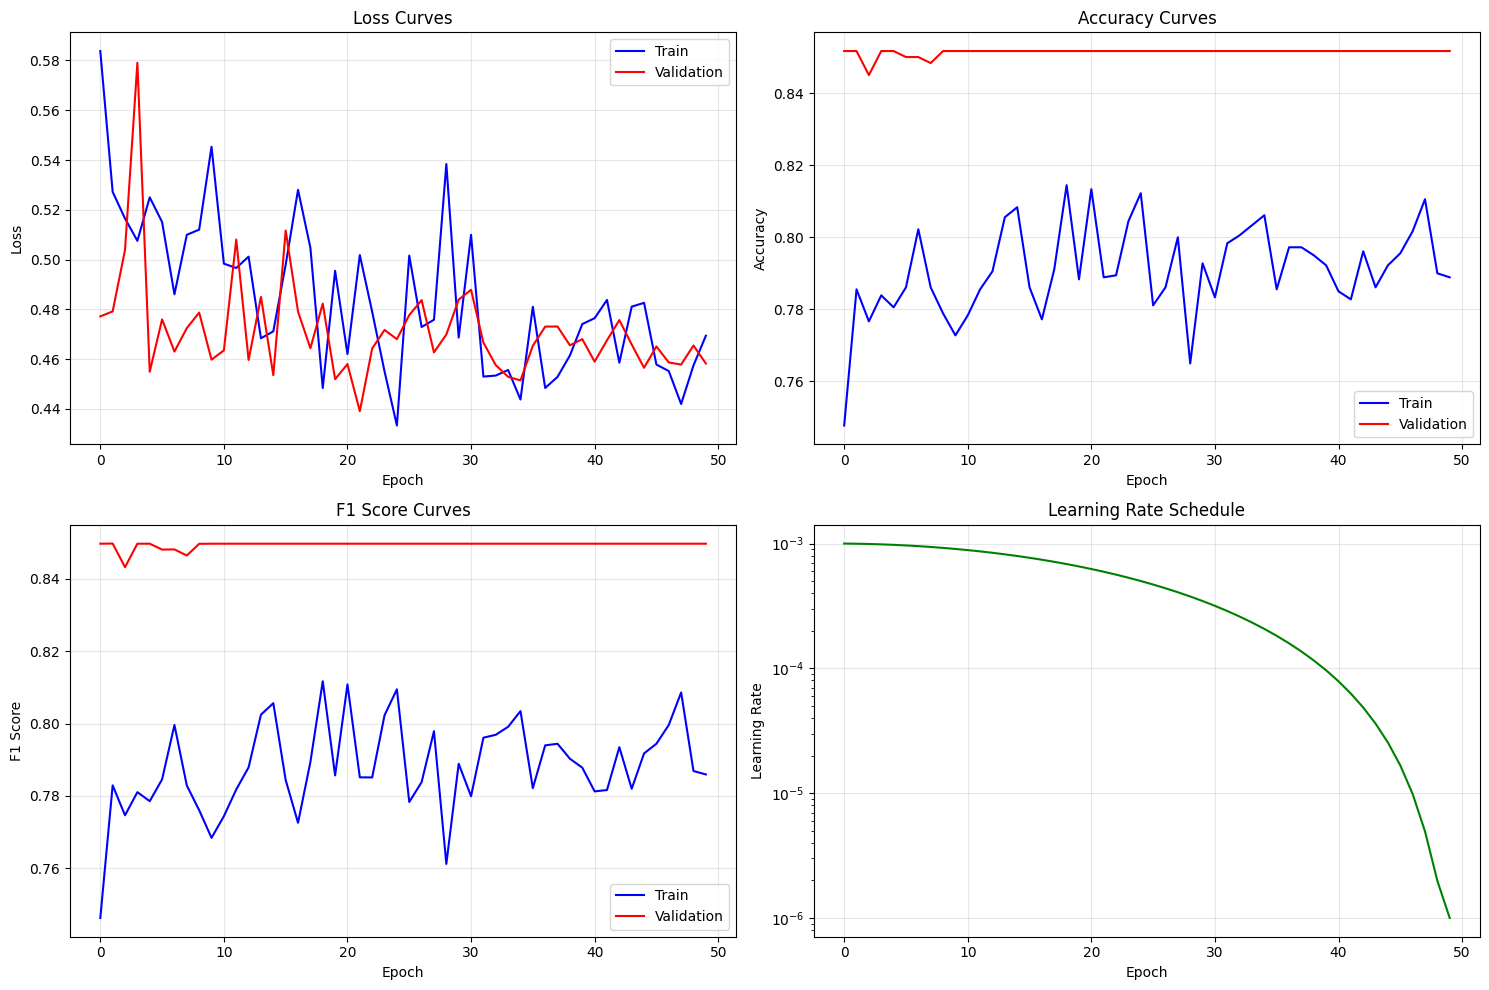

Loading best model...

Evaluating model on test set...


Evaluating: 100%|██████████| 19/19 [00:00<00:00, 40.97it/s]



=== PERFORMANCE METRICS ===
                 precision    recall  f1-score   support

        healthy      0.844     0.936     0.887       219
    mild_stress      0.834     0.894     0.863       141
moderate_stress      0.877     0.847     0.862       118
  severe_stress      0.833     0.753     0.791        73
        drought      0.962     0.510     0.667        49

       accuracy                          0.852       600
      macro avg      0.870     0.788     0.814       600
   weighted avg      0.856     0.852     0.847       600

Weighted F1 Score: 0.847
Weighted AUC Score: 0.902

Generating visualizations...


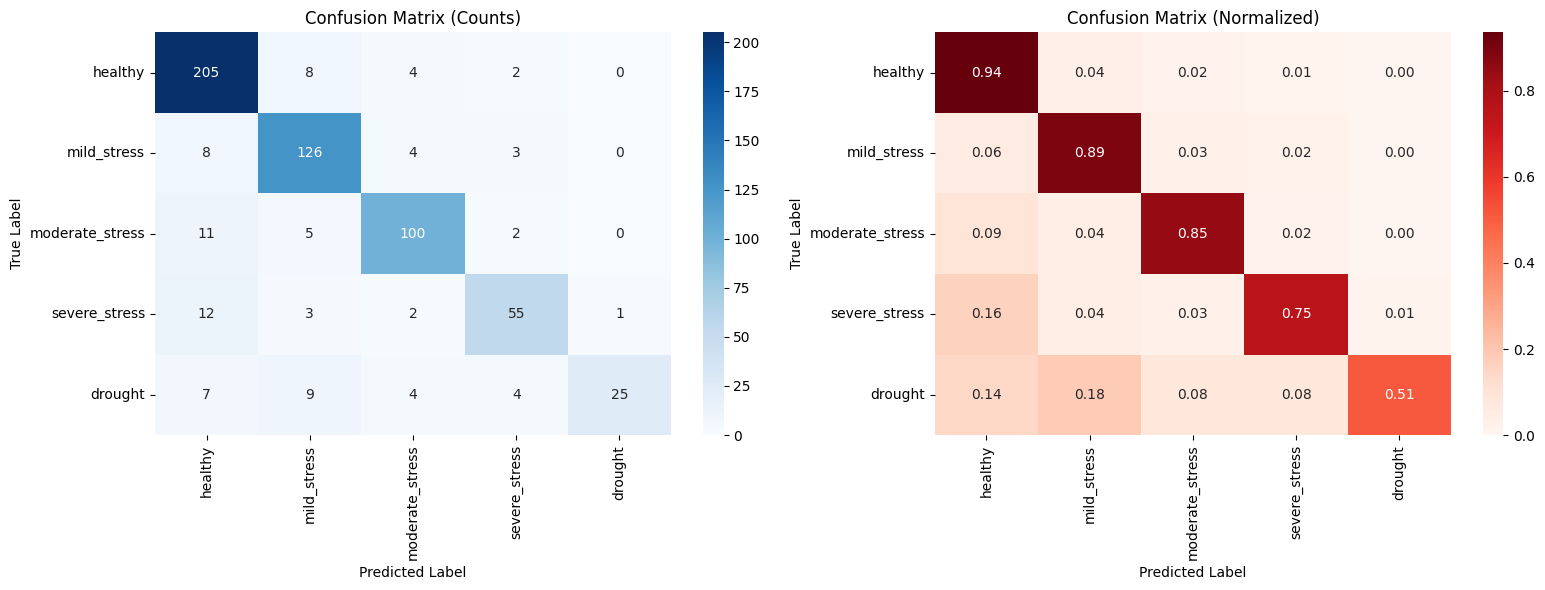

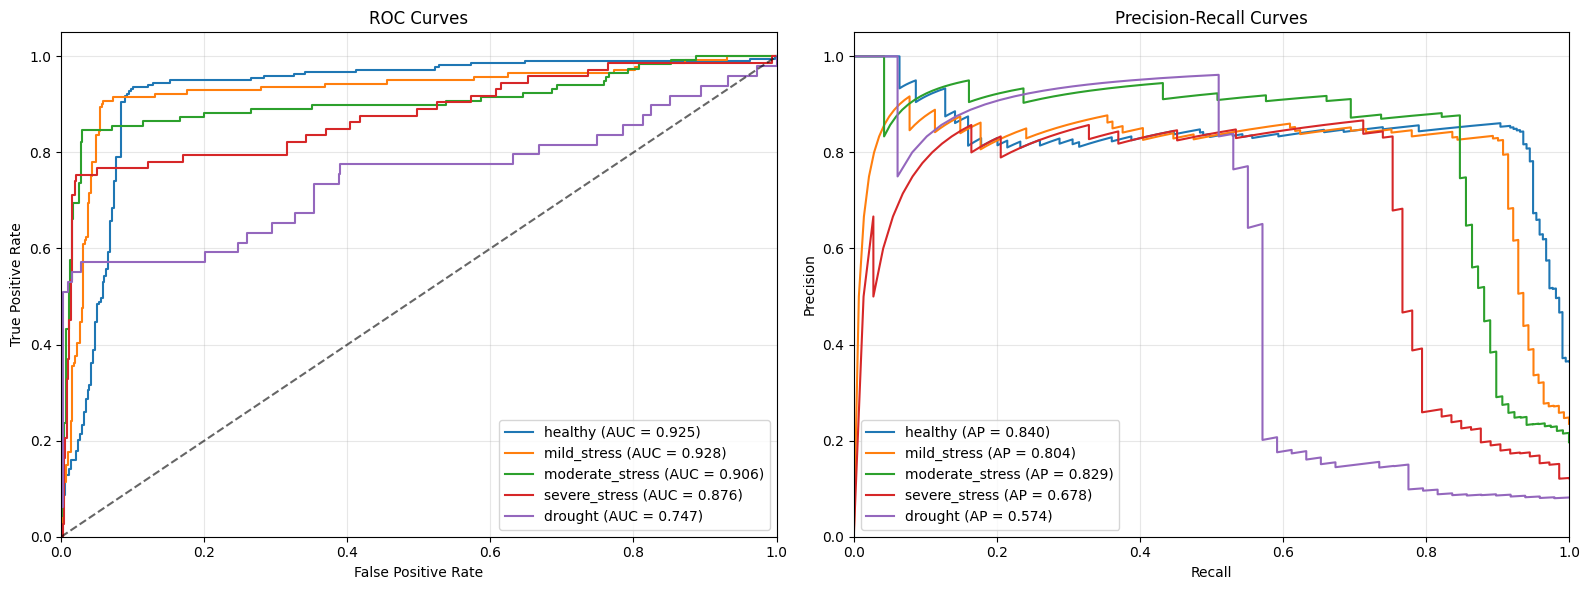

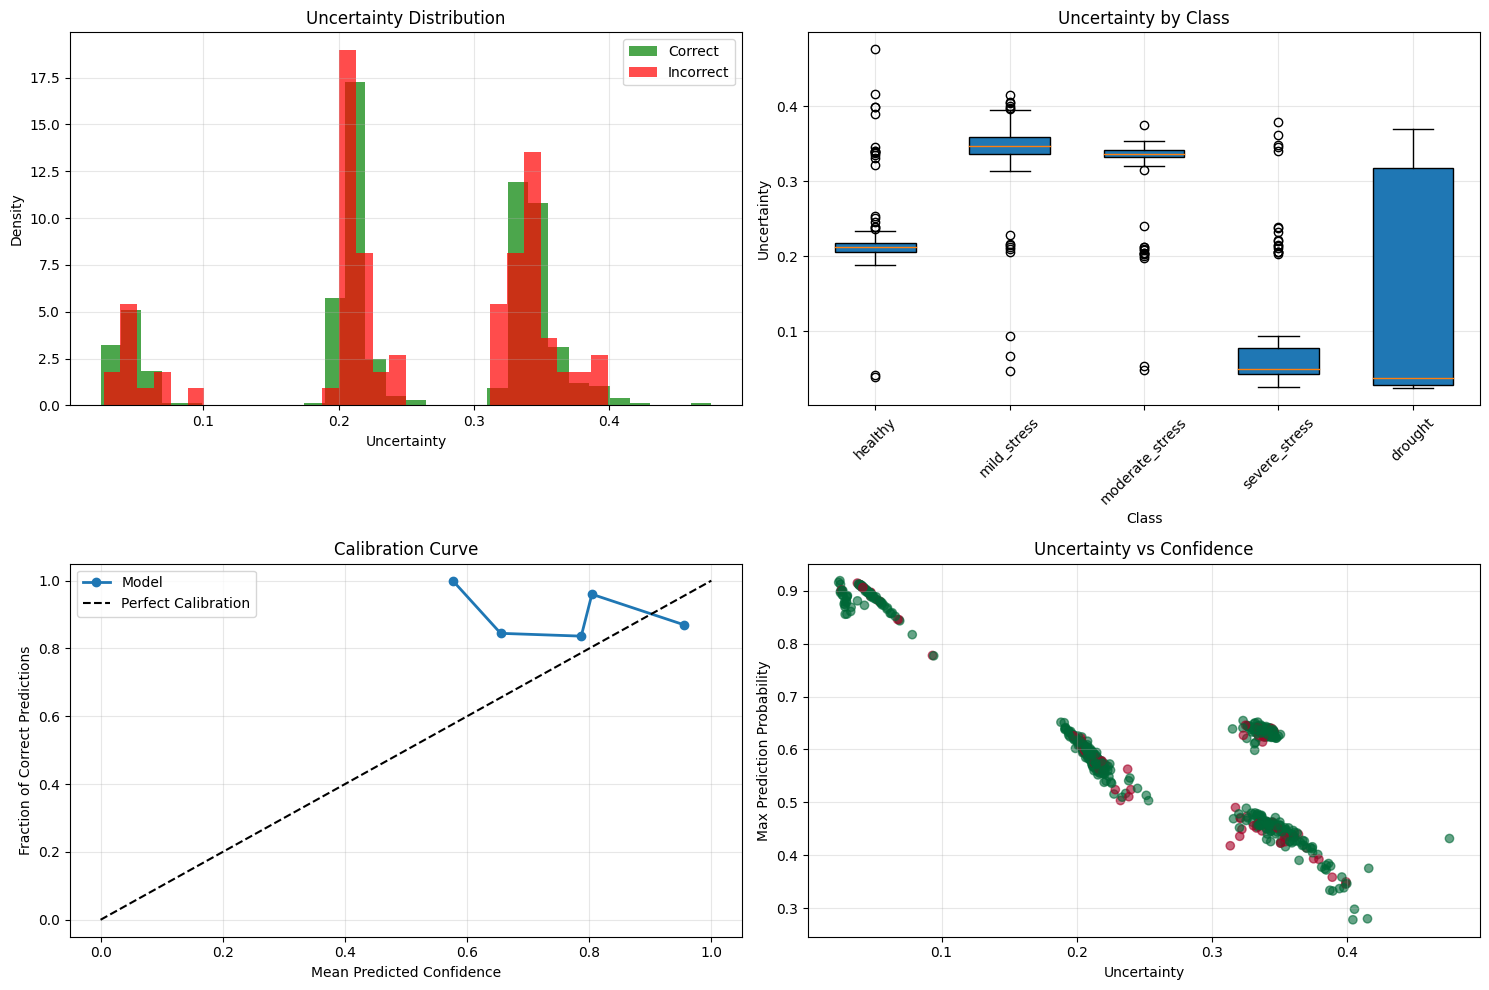

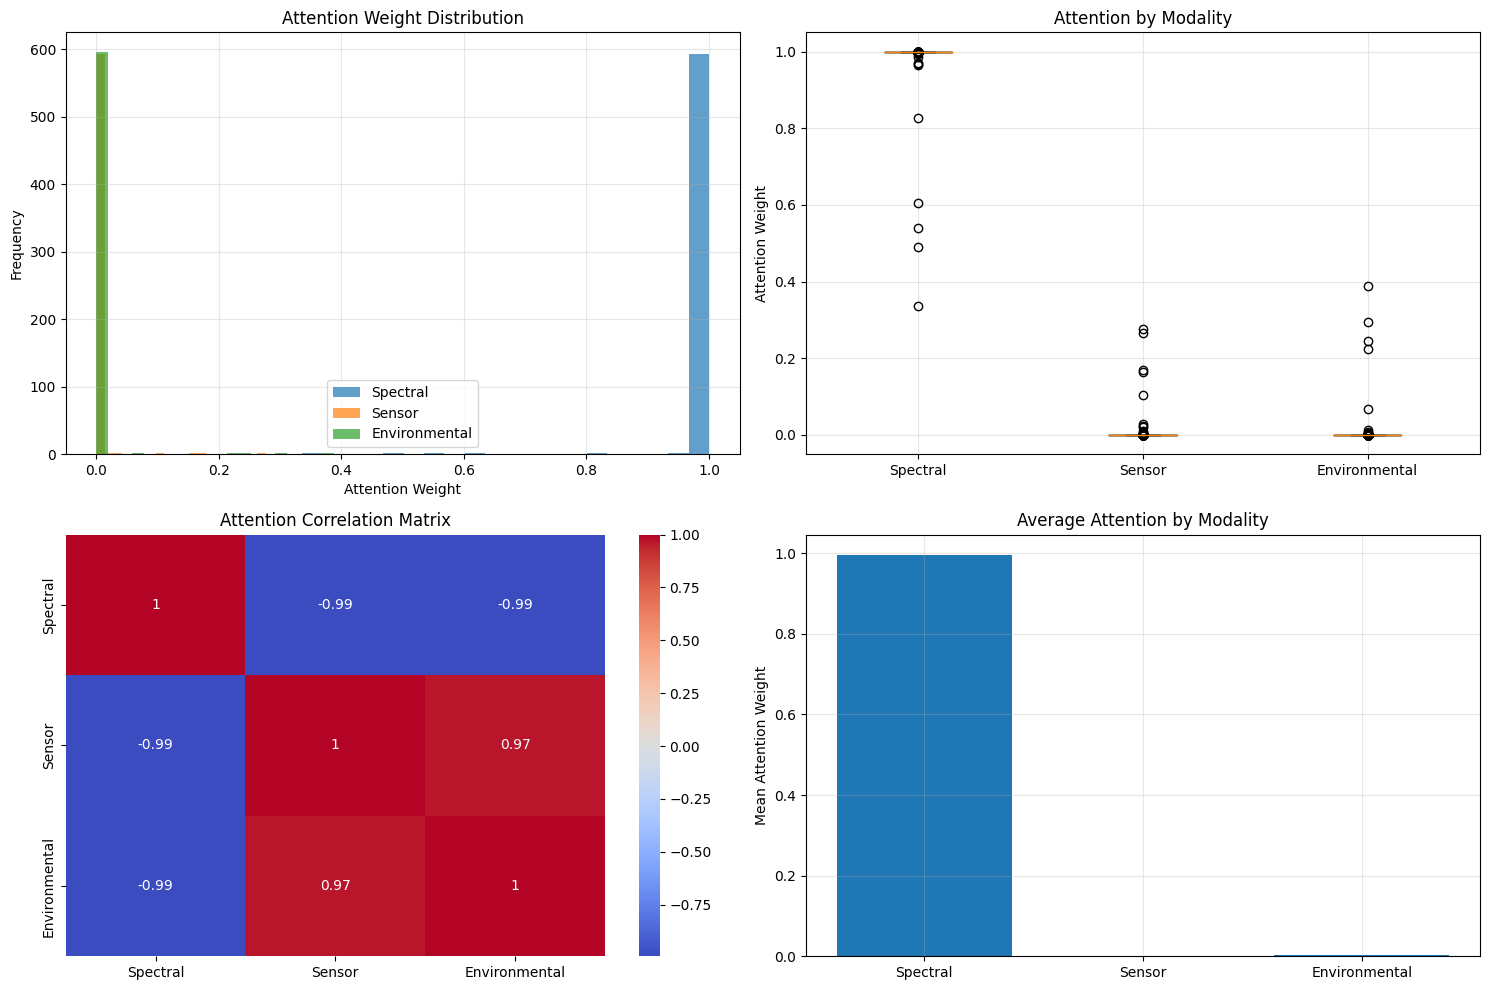

=== ERROR ANALYSIS ===

Most Confident Wrong Predictions: 11
  True: drought, Pred: severe_stress, Conf: 0.846, Unc: 0.068
  True: moderate_stress, Pred: severe_stress, Conf: 0.897, Unc: 0.048
  True: drought, Pred: severe_stress, Conf: 0.891, Unc: 0.047
  True: drought, Pred: severe_stress, Conf: 0.915, Unc: 0.038
  True: mild_stress, Pred: severe_stress, Conf: 0.846, Unc: 0.067

Uncertain Correct Predictions: 0

Analyzing feature importance...


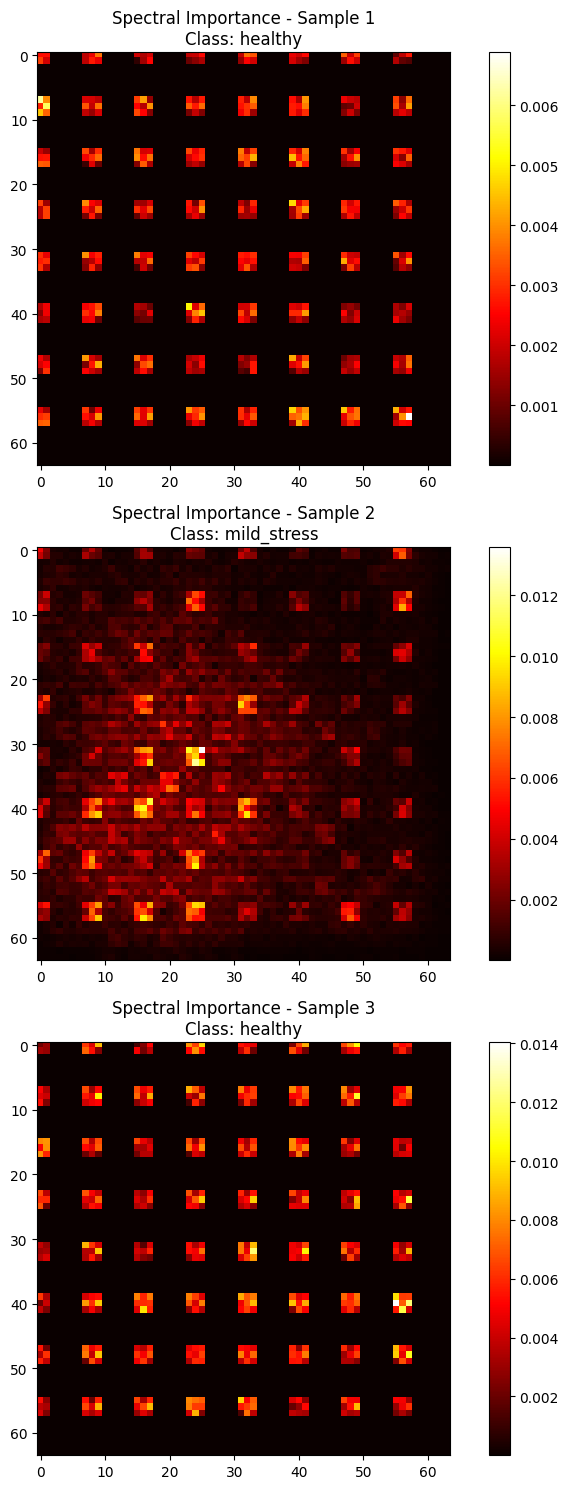


=== ANALYSIS COMPLETE ===
Enhanced crop health classification system evaluation finished!
Final Test Accuracy: 0.852
Final Test F1 Score: 0.847
Final Test AUC Score: 0.902


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (classification_report, confusion_matrix,
                           roc_auc_score, roc_curve, auc, precision_recall_curve,
                           average_precision_score, f1_score)
from tqdm import tqdm
from sklearn.manifold import TSNE
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ----------------------------
# 1. ENHANCED DATA GENERATION
# ----------------------------
class EnhancedCropDataset(Dataset):
    def __init__(self, num_samples=2000, split='train', severity_levels=True):
        self.split = split
        self.severity_levels = severity_levels

        if severity_levels:
            # More granular classes with severity levels
            self.classes = ['healthy', 'mild_stress', 'moderate_stress', 'severe_stress', 'drought']
            # Realistic distribution (40-25-20-10-5)
            self.labels = np.random.choice(
                self.classes,
                size=num_samples,
                p=[0.40, 0.25, 0.20, 0.10, 0.05]
            )
        else:
            self.classes = ['healthy', 'unhealthy', 'drought']
            self.labels = np.random.choice(
                self.classes,
                size=num_samples,
                p=[0.6, 0.3, 0.1]
            )

        # Generate multi-spectral NDVI data (RGB, NIR, SWIR)
        self.spectral_data = [self._generate_multispectral(label) for label in self.labels]

        # Enhanced sensor data with temporal context
        self.sensor_data = [self._generate_enhanced_sensors(label) for label in self.labels]

        # Environmental context
        self.environmental_data = [self._generate_environmental(label) for label in self.labels]

        # Reduced label noise (15% for training, 0% for validation/test)
        noise_rate = 0.15 if split == 'train' else 0.0
        for i in range(len(self.labels)):
            if np.random.rand() < noise_rate:
                available_classes = [c for c in self.classes if c != self.labels[i]]
                self.labels[i] = np.random.choice(available_classes)

    def _generate_multispectral(self, label):
        """Generate realistic multi-spectral imagery"""
        # Initialize base patterns
        base_pattern = self._generate_field_pattern()

        # RGB channels
        rgb = np.zeros((3, 64, 64))
        # NIR channel
        nir = np.zeros((64, 64))
        # SWIR channel
        swir = np.zeros((64, 64))

        if label == "healthy":
            # High chlorophyll (green), high NIR reflectance
            rgb[0] = np.random.normal(0.2, 0.05, (64, 64))  # Red
            rgb[1] = np.random.normal(0.6, 0.1, (64, 64))   # Green
            rgb[2] = np.random.normal(0.3, 0.05, (64, 64))  # Blue
            nir = np.random.normal(0.8, 0.1, (64, 64))      # High NIR
            swir = np.random.normal(0.3, 0.08, (64, 64))    # Low SWIR

        elif label in ["mild_stress", "moderate_stress"]:
            stress_factor = 0.7 if label == "mild_stress" else 0.5
            rgb[0] = np.random.normal(0.3, 0.08, (64, 64))
            rgb[1] = np.random.normal(0.5 * stress_factor, 0.12, (64, 64))
            rgb[2] = np.random.normal(0.25, 0.06, (64, 64))
            nir = np.random.normal(0.7 * stress_factor, 0.12, (64, 64))
            swir = np.random.normal(0.4, 0.1, (64, 64))

        elif label == "severe_stress":
            rgb[0] = np.random.normal(0.4, 0.1, (64, 64))   # More red
            rgb[1] = np.random.normal(0.35, 0.15, (64, 64)) # Less green
            rgb[2] = np.random.normal(0.2, 0.08, (64, 64))
            nir = np.random.normal(0.5, 0.15, (64, 64))     # Lower NIR
            swir = np.random.normal(0.55, 0.12, (64, 64))   # Higher SWIR

        else:  # drought
            rgb[0] = np.random.normal(0.5, 0.12, (64, 64))  # Brown/red
            rgb[1] = np.random.normal(0.25, 0.12, (64, 64)) # Very low green
            rgb[2] = np.random.normal(0.15, 0.08, (64, 64))
            nir = np.random.normal(0.3, 0.15, (64, 64))     # Very low NIR
            swir = np.random.normal(0.7, 0.15, (64, 64))    # High SWIR

        # Apply field pattern and clip values
        for i in range(3):
            rgb[i] = np.clip(rgb[i] * base_pattern, 0, 1)
        nir = np.clip(nir * base_pattern, 0, 1)
        swir = np.clip(swir * base_pattern, 0, 1)

        # Stack all channels [RGB + NIR + SWIR] = 5 channels
        return np.vstack([rgb, nir[np.newaxis], swir[np.newaxis]])

    def _generate_field_pattern(self):
        """Generate realistic field patterns"""
        # Create field rows/patterns
        pattern = np.ones((64, 64))

        # Add row structure (common in agriculture)
        if np.random.rand() < 0.7:
            row_width = np.random.randint(3, 8)
            for i in range(0, 64, row_width*2):
                pattern[i:i+row_width//2] *= 0.9

        # Add irrigation patterns
        if np.random.rand() < 0.4:
            center_x, center_y = np.random.randint(16, 48, 2)
            y, x = np.ogrid[:64, :64]
            mask = (x - center_x)**2 + (y - center_y)**2 < np.random.randint(200, 600)
            pattern[mask] *= 1.1

        return np.clip(pattern, 0.7, 1.3)

    def _generate_enhanced_sensors(self, label):
        """Generate comprehensive sensor data with temporal context"""
        base_sensors = self._generate_base_sensors(label)

        # Add temporal data (7-day history)
        temporal_data = []
        for day in range(7):
            day_factor = 1 + np.random.normal(0, 0.1)
            temporal_data.extend([s * day_factor for s in base_sensors])

        return base_sensors + temporal_data  # Current + 7-day history

    def _generate_base_sensors(self, label):
        """Generate base sensor readings"""
        if label == "healthy":
            return [
                np.clip(np.random.normal(22, 3), 15, 35),    # Temperature (°C)
                np.clip(np.random.normal(65, 8), 40, 90),    # Humidity (%)
                np.clip(np.random.normal(75, 10), 50, 95),   # Soil moisture (%)
                np.clip(np.random.normal(6.8, 0.4), 5.5, 8.0), # pH
                np.clip(np.random.normal(0.8, 0.1), 0.5, 1.2), # NDVI
                np.clip(np.random.normal(1200, 200), 800, 1800), # Light intensity (lux)
                np.clip(np.random.normal(15, 5), 5, 30),     # Wind speed (km/h)
                np.clip(np.random.normal(0.05, 0.1), 0, 0.5) # Rainfall (mm/day)
            ]
        elif label in ["mild_stress", "moderate_stress"]:
            stress_factor = 0.9 if label == "mild_stress" else 0.8
            return [
                np.clip(np.random.normal(25, 4), 15, 35),
                np.clip(np.random.normal(60 * stress_factor, 10), 40, 90),
                np.clip(np.random.normal(65 * stress_factor, 12), 50, 95),
                np.clip(np.random.normal(6.5, 0.5), 5.5, 8.0),
                np.clip(np.random.normal(0.7 * stress_factor, 0.12), 0.5, 1.2),
                np.clip(np.random.normal(1100, 250), 800, 1800),
                np.clip(np.random.normal(18, 6), 5, 30),
                np.clip(np.random.normal(0.03, 0.08), 0, 0.5)
            ]
        elif label == "severe_stress":
            return [
                np.clip(np.random.normal(28, 5), 15, 35),
                np.clip(np.random.normal(45, 12), 40, 90),
                np.clip(np.random.normal(50, 15), 50, 95),
                np.clip(np.random.normal(6.2, 0.6), 5.5, 8.0),
                np.clip(np.random.normal(0.5, 0.15), 0.5, 1.2),
                np.clip(np.random.normal(1000, 300), 800, 1800),
                np.clip(np.random.normal(22, 8), 5, 30),
                np.clip(np.random.normal(0.01, 0.05), 0, 0.5)
            ]
        else:  # drought
            return [
                np.clip(np.random.normal(32, 6), 15, 35),
                np.clip(np.random.normal(30, 12), 40, 90),
                np.clip(np.random.normal(35, 15), 50, 95),
                np.clip(np.random.normal(5.8, 0.7), 5.5, 8.0),
                np.clip(np.random.normal(0.3, 0.12), 0.5, 1.2),
                np.clip(np.random.normal(1300, 200), 800, 1800),
                np.clip(np.random.normal(25, 10), 5, 30),
                np.clip(np.random.normal(0.0, 0.02), 0, 0.5)
            ]

    def _generate_environmental(self, label):
        """Generate environmental context data"""
        # Season, location, soil type, etc.
        season = np.random.randint(0, 4)  # 0=spring, 1=summer, 2=fall, 3=winter
        soil_type = np.random.randint(0, 5)  # Different soil types
        elevation = np.random.normal(200, 100)  # Elevation in meters
        slope = np.random.normal(5, 3)  # Slope in degrees

        return [season, soil_type, elevation, slope]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        spectral = self.spectral_data[idx].copy()
        sensors = self.sensor_data[idx].copy()
        environmental = self.environmental_data[idx].copy()
        label = self.classes.index(self.labels[idx])

        # Enhanced data augmentation for training
        if self.split == 'train':
            spectral = self._augment_spectral(spectral)
            sensors = self._augment_sensors(sensors)

        # Normalize spectral data
        spectral = (spectral - 0.5) * 2.0  # [-1, 1] range

        return (
            torch.FloatTensor(spectral),           # [5, 64, 64] - multispectral
            torch.FloatTensor(sensors),            # [64] - current + temporal sensors
            torch.FloatTensor(environmental),      # [4] - environmental context
            torch.LongTensor([label])              # [1] - class label
        )

    def _augment_spectral(self, spectral):
        """Enhanced spectral data augmentation"""
        # Geometric augmentations
        if np.random.rand() > 0.5:
            spectral = np.flip(spectral, axis=2)  # Horizontal flip
        if np.random.rand() > 0.5:
            spectral = np.flip(spectral, axis=1)  # Vertical flip
        if np.random.rand() > 0.7:
            # Random rotation (90, 180, 270 degrees)
            k = np.random.randint(1, 4)
            spectral = np.rot90(spectral, k, axes=(1, 2))

        # Spectral augmentations
        if np.random.rand() < 0.3:
            # Simulate atmospheric conditions
            spectral += np.random.normal(0, 0.05, spectral.shape)

        if np.random.rand() < 0.2:
            # Simulate cloud shadows
            shadow_size = np.random.randint(15, 35)
            x, y = np.random.randint(0, 64-shadow_size, 2)
            spectral[:, x:x+shadow_size, y:y+shadow_size] *= np.random.uniform(0.3, 0.7)

        return np.clip(spectral, -1, 1)

    def _augment_sensors(self, sensors):
        """Sensor data augmentation"""
        # Add realistic sensor noise
        noise_factor = np.random.normal(1, 0.08, len(sensors))
        return [s * n for s, n in zip(sensors, noise_factor)]

# ----------------------------
# 2. ADVANCED MODEL ARCHITECTURES
# ----------------------------
class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=7, padding=3)

    def forward(self, x):
        attention = torch.sigmoid(self.conv(x))
        return x * attention

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction),
            nn.ReLU(),
            nn.Linear(in_channels // reduction, in_channels)
        )

    def forward(self, x):
        b, c, h, w = x.size()

        avg_out = self.fc(self.avg_pool(x).view(b, c))
        max_out = self.fc(self.max_pool(x).view(b, c))

        attention = torch.sigmoid(avg_out + max_out).view(b, c, 1, 1)
        return x * attention

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride),
                nn.BatchNorm2d(out_channels)
            )

        self.channel_attention = ChannelAttention(out_channels)
        self.spatial_attention = SpatialAttention(out_channels)

    def forward(self, x):
        residual = self.shortcut(x)

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        # Apply attention mechanisms
        out = self.channel_attention(out)
        out = self.spatial_attention(out)

        out += residual
        return F.relu(out)

class MultiModalFusionModel(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()

        # Spectral processing backbone
        self.spectral_backbone = nn.Sequential(
            nn.Conv2d(5, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            ResidualBlock(32, 64, stride=2),
            ResidualBlock(64, 128, stride=2),
            ResidualBlock(128, 256, stride=2),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )

        # Sensor processing network with temporal awareness
        self.sensor_temporal = nn.LSTM(8, 32, batch_first=True, num_layers=2, dropout=0.3)
        self.sensor_net = nn.Sequential(
            nn.Linear(32 + 8, 128),  # LSTM output + current sensors
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 128)
        )

        # Environmental context network
        self.env_net = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Linear(32, 64)
        )

        # Multi-head attention for feature fusion
        self.multihead_attention = nn.MultiheadAttention(
            embed_dim=256, num_heads=8, dropout=0.2, batch_first=True
        )

        # Cross-modal attention
        self.cross_attention = nn.Sequential(
            nn.Linear(256 + 128 + 64, 128),
            nn.ReLU(),
            nn.Linear(128, 3),  # Attention weights for 3 modalities
            nn.Softmax(dim=1)
        )

        # Final classifier with uncertainty estimation
        self.classifier = nn.Sequential(
            nn.Linear(256 + 128 + 64, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

        # Uncertainty estimation head
        self.uncertainty_head = nn.Sequential(
            nn.Linear(256 + 128 + 64, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, spectral, sensors, environmental):
        batch_size = spectral.size(0)

        # Process spectral data
        spectral_features = self.spectral_backbone(spectral)  # [B, 256]

        # Process temporal sensor data
        sensor_temporal = sensors[:, :56].view(batch_size, 7, 8)  # Reshape for LSTM
        sensor_current = sensors[:, :8]  # Current readings

        lstm_out, _ = self.sensor_temporal(sensor_temporal)
        lstm_features = lstm_out[:, -1, :]  # Last timestep

        sensor_input = torch.cat([lstm_features, sensor_current], dim=1)
        sensor_features = self.sensor_net(sensor_input)  # [B, 128]

        # Process environmental data
        env_features = self.env_net(environmental)  # [B, 64]

        # Apply multi-head self-attention to spectral features
        spectral_attended, _ = self.multihead_attention(
            spectral_features.unsqueeze(1),
            spectral_features.unsqueeze(1),
            spectral_features.unsqueeze(1)
        )
        spectral_attended = spectral_attended.squeeze(1)

        # Cross-modal attention fusion
        combined_features = torch.cat([spectral_attended, sensor_features, env_features], dim=1)
        attention_weights = self.cross_attention(combined_features)

        # Apply attention weights
        weighted_spectral = spectral_attended * attention_weights[:, 0].unsqueeze(1)
        weighted_sensor = sensor_features * attention_weights[:, 1].unsqueeze(1)
        weighted_env = env_features * attention_weights[:, 2].unsqueeze(1)

        # Final fusion
        fused_features = torch.cat([weighted_spectral, weighted_sensor, weighted_env], dim=1)

        # Predictions
        logits = self.classifier(fused_features)
        uncertainty = self.uncertainty_head(fused_features)

        return logits, uncertainty, attention_weights

# ----------------------------
# 3. ADVANCED TRAINING UTILITIES
# ----------------------------
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

def create_weighted_sampler(dataset):
    """Create weighted sampler for imbalanced dataset"""
    class_counts = {}
    for i in range(len(dataset)):
        label = dataset[i][3].item()  # Get label
        class_counts[label] = class_counts.get(label, 0) + 1

    # Calculate weights
    total_samples = len(dataset)
    class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

    # Create sample weights
    sample_weights = []
    for i in range(len(dataset)):
        label = dataset[i][3].item()
        sample_weights.append(class_weights[label])

    return WeightedRandomSampler(sample_weights, len(sample_weights))

def train_advanced_model(model, train_loader, val_loader, epochs=50, use_focal_loss=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Training on device: {device}")

    model = model.to(device)

    # Advanced optimizer and scheduler
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

    # Loss functions
    if use_focal_loss:
        classification_criterion = FocalLoss(alpha=1, gamma=2)
    else:
        classification_criterion = nn.CrossEntropyLoss()

    uncertainty_criterion = nn.BCELoss()

    best_val_f1 = 0
    history = {
        'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [],
        'train_f1': [], 'val_f1': [], 'learning_rates': []
    }

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        train_preds, train_labels = [], []

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        for spectral, sensors, env, labels in pbar:
            spectral = spectral.to(device)
            sensors = sensors.to(device)
            env = env.to(device)
            labels = labels.to(device).squeeze()

            optimizer.zero_grad()

            logits, uncertainty, attention = model(spectral, sensors, env)

            # Classification loss
            class_loss = classification_criterion(logits, labels)

            # Uncertainty loss (encourage high uncertainty for misclassified samples)
            preds = logits.argmax(1)
            uncertainty_targets = (preds != labels).float()
            uncertainty_loss = uncertainty_criterion(uncertainty.squeeze(), uncertainty_targets)

            total_loss = class_loss + 0.1 * uncertainty_loss
            total_loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += total_loss.item()
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

            # Update progress bar
            pbar.set_postfix({
                'Loss': f'{total_loss.item():.4f}',
                'Acc': f'{train_correct/train_total:.3f}'
            })

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        val_preds, val_labels = [], []

        with torch.no_grad():
            for spectral, sensors, env, labels in val_loader:
                spectral = spectral.to(device)
                sensors = sensors.to(device)
                env = env.to(device)
                labels = labels.to(device).squeeze()

                logits, uncertainty, attention = model(spectral, sensors, env)

                class_loss = classification_criterion(logits, labels)
                preds = logits.argmax(1)
                uncertainty_targets = (preds != labels).float()
                uncertainty_loss = uncertainty_criterion(uncertainty.squeeze(), uncertainty_targets)

                total_loss = class_loss + 0.1 * uncertainty_loss

                val_loss += total_loss.item()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        # Calculate metrics
        train_loss /= len(train_loader)
        train_acc = train_correct / train_total
        train_f1 = f1_score(train_labels, train_preds, average='weighted')

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        val_f1 = f1_score(val_labels, val_preds, average='weighted')

        # Update learning rate
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']

        # Store history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)
        history['learning_rates'].append(current_lr)

        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        print(f"Train Acc: {train_acc:.3f}, Val Acc: {val_acc:.3f}")
        print(f"Train F1: {train_f1:.3f}, Val F1: {val_f1:.3f}, LR: {current_lr:.6f}")
        print("-" * 60)

        # Save best model based on F1 score
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'val_f1': val_f1,
                'history': history
            }, 'best_advanced_model.pth')

    # Plot enhanced training curves
    plot_training_curves(history)

    return model, history

def plot_training_curves(history):
    """Plot comprehensive training curves"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss curves
    axes[0,0].plot(history['train_loss'], label='Train', color='blue')
    axes[0,0].plot(history['val_loss'], label='Validation', color='red')
    axes[0,0].set_title('Loss Curves')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # Accuracy curves
    axes[0,1].plot(history['train_acc'], label='Train', color='blue')
    axes[0,1].plot(history['val_acc'], label='Validation', color='red')
    axes[0,1].set_title('Accuracy Curves')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Accuracy')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # F1 Score curves
    axes[1,0].plot(history['train_f1'], label='Train', color='blue')
    axes[1,0].plot(history['val_f1'], label='Validation', color='red')
    axes[1,0].set_title('F1 Score Curves')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('F1 Score')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # Learning rate curve
    axes[1,1].plot(history['learning_rates'], color='green')
    axes[1,1].set_title('Learning Rate Schedule')
    axes[1,1].set_xlabel('Epoch')
    axes[1,1].set_ylabel('Learning Rate')
    axes[1,1].set_yscale('log')
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# ----------------------------
# 4. COMPREHENSIVE EVALUATION
# ----------------------------
def evaluate_advanced_model(model, loader, class_names):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    all_labels = []
    all_preds = []
    all_probs = []
    all_uncertainties = []
    all_attention = []

    with torch.no_grad():
        for spectral, sensors, env, labels in tqdm(loader, desc="Evaluating"):
            spectral = spectral.to(device)
            sensors = sensors.to(device)
            env = env.to(device)
            labels = labels.to(device).squeeze()

            logits, uncertainty, attention = model(spectral, sensors, env)

            probs = F.softmax(logits, dim=1)
            preds = logits.argmax(1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_uncertainties.extend(uncertainty.cpu().numpy())
            all_attention.extend(attention.cpu().numpy())

    return (np.array(all_labels), np.array(all_preds),
            np.array(all_probs), np.array(all_uncertainties),
            np.array(all_attention))

def plot_enhanced_confusion_matrix(labels, preds, class_names):
    """Enhanced confusion matrix with additional metrics"""
    cm = confusion_matrix(labels, preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Raw counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax1)
    ax1.set_title('Confusion Matrix (Counts)')
    ax1.set_ylabel('True Label')
    ax1.set_xlabel('Predicted Label')

    # Normalized
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Reds',
                xticklabels=class_names, yticklabels=class_names, ax=ax2)
    ax2.set_title('Confusion Matrix (Normalized)')
    ax2.set_ylabel('True Label')
    ax2.set_xlabel('Predicted Label')

    plt.tight_layout()
    plt.show()

def plot_roc_and_pr_curves(labels, probs, class_names):
    """Plot both ROC and Precision-Recall curves"""
    n_classes = len(class_names)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # ROC Curves
    for i, name in enumerate(class_names):
        fpr, tpr, _ = roc_curve((labels == i), probs[:, i])
        roc_auc = auc(fpr, tpr)
        ax1.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

    ax1.plot([0, 1], [0, 1], 'k--', alpha=0.6)
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curves')
    ax1.legend(loc="lower right")
    ax1.grid(True, alpha=0.3)

    # Precision-Recall Curves
    for i, name in enumerate(class_names):
        precision, recall, _ = precision_recall_curve((labels == i), probs[:, i])
        avg_precision = average_precision_score((labels == i), probs[:, i])
        ax2.plot(recall, precision, label=f'{name} (AP = {avg_precision:.3f})')

    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curves')
    ax2.legend(loc="lower left")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_uncertainty_analysis(labels, preds, uncertainties, class_names, test_probs):
    """Analyze model uncertainty patterns"""
    correct_mask = (labels == preds)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Uncertainty distribution for correct vs incorrect predictions
    axes[0,0].hist(uncertainties[correct_mask], bins=30, alpha=0.7,
                   label='Correct', color='green', density=True)
    axes[0,0].hist(uncertainties[~correct_mask], bins=30, alpha=0.7,
                   label='Incorrect', color='red', density=True)
    axes[0,0].set_xlabel('Uncertainty')
    axes[0,0].set_ylabel('Density')
    axes[0,0].set_title('Uncertainty Distribution')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # Uncertainty by class
    for i, name in enumerate(class_names):
        class_mask = (labels == i)
        if np.sum(class_mask) > 0:
            axes[0,1].boxplot(uncertainties[class_mask], positions=[i],
                            widths=0.6, patch_artist=True)
    axes[0,1].set_xlabel('Class')
    axes[0,1].set_ylabel('Uncertainty')
    axes[0,1].set_title('Uncertainty by Class')
    axes[0,1].set_xticks(range(len(class_names)))
    axes[0,1].set_xticklabels(class_names, rotation=45)
    axes[0,1].grid(True, alpha=0.3)

    # Calibration curve
    from sklearn.calibration import calibration_curve

    binary_labels = (labels == preds).astype(int)
    prob_true, prob_pred = calibration_curve(binary_labels, 1 - uncertainties.flatten(), n_bins=10)

    axes[1,0].plot(prob_pred, prob_true, marker='o', linewidth=2, label='Model')
    axes[1,0].plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
    axes[1,0].set_xlabel('Mean Predicted Confidence')
    axes[1,0].set_ylabel('Fraction of Correct Predictions')
    axes[1,0].set_title('Calibration Curve')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # Uncertainty vs confidence scatter
    max_probs = np.max(test_probs, axis=1)  # ✅ Use test_probs
    axes[1,1].scatter(uncertainties.flatten(), max_probs, alpha=0.6, c=correct_mask, cmap='RdYlGn')
    axes[1,1].set_xlabel('Uncertainty')
    axes[1,1].set_ylabel('Max Prediction Probability')
    axes[1,1].set_title('Uncertainty vs Confidence')
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_attention_analysis(attention_weights, class_names):
    """Analyze attention patterns across modalities"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Attention distribution
    modality_names = ['Spectral', 'Sensor', 'Environmental']
    for i, name in enumerate(modality_names):
        axes[0,0].hist(attention_weights[:, i], bins=20, alpha=0.7, label=name)
    axes[0,0].set_xlabel('Attention Weight')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].set_title('Attention Weight Distribution')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # Attention by modality (box plot)
    data_to_plot = [attention_weights[:, i] for i in range(3)]
    axes[0,1].boxplot(data_to_plot, labels=modality_names)
    axes[0,1].set_ylabel('Attention Weight')
    axes[0,1].set_title('Attention by Modality')
    axes[0,1].grid(True, alpha=0.3)

    # Attention correlation matrix
    import pandas as pd
    df = pd.DataFrame(attention_weights, columns=modality_names)
    correlation_matrix = df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,0])
    axes[1,0].set_title('Attention Correlation Matrix')

    # Attention weights over predictions
    attention_mean = np.mean(attention_weights, axis=0)
    axes[1,1].bar(modality_names, attention_mean)
    axes[1,1].set_ylabel('Mean Attention Weight')
    axes[1,1].set_title('Average Attention by Modality')
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def perform_error_analysis(labels, preds, probs, uncertainties, class_names):
    """Comprehensive error analysis"""
    print("=== ERROR ANALYSIS ===")

    # Most confident wrong predictions
    wrong_mask = (labels != preds)
    if np.sum(wrong_mask) > 0:
        max_probs = np.max(probs, axis=1)
        confident_wrong = wrong_mask & (max_probs > 0.8)

        print(f"\nMost Confident Wrong Predictions: {np.sum(confident_wrong)}")
        if np.sum(confident_wrong) > 0:
            for i in np.where(confident_wrong)[0][:5]:  # Show top 5
                true_class = class_names[labels[i]]
                pred_class = class_names[preds[i]]
                confidence = max_probs[i]
                uncertainty = uncertainties[i, 0] if uncertainties.ndim > 1 else uncertainties[i]
                print(f"  True: {true_class}, Pred: {pred_class}, "
                      f"Conf: {confidence:.3f}, Unc: {uncertainty:.3f}")

    # Uncertain correct predictions
    correct_mask = (labels == preds)
    if np.sum(correct_mask) > 0:
        uncertain_correct = correct_mask & (uncertainties.flatten() > 0.5)
        print(f"\nUncertain Correct Predictions: {np.sum(uncertain_correct)}")

        if np.sum(uncertain_correct) > 0:
            for i in np.where(uncertain_correct)[0][:5]:  # Show top 5
                true_class = class_names[labels[i]]
                max_prob = np.max(probs[i])
                uncertainty = uncertainties[i, 0] if uncertainties.ndim > 1 else uncertainties[i]
                print(f"  Class: {true_class}, Conf: {max_prob:.3f}, Unc: {uncertainty:.3f}")

def cross_validate_model(dataset, model_class, k_folds=5, num_classes=5):
    """Perform k-fold cross validation"""
    print(f"Performing {k_folds}-fold cross validation...")

    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

    # Get labels for stratification
    all_labels = [dataset.labels[i] for i in range(len(dataset))]
    label_indices = [dataset.classes.index(label) for label in all_labels]

    cv_scores = {'accuracy': [], 'f1': [], 'auc': []}

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.arange(len(dataset)), label_indices)):
        print(f"\nFold {fold + 1}/{k_folds}")

        # Create data loaders
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

        # Initialize model
        model = model_class(num_classes=num_classes)

        # Train model (reduced epochs for CV)
        model, _ = train_advanced_model(model, train_loader, val_loader, epochs=20, use_focal_loss=True)

        # Evaluate
        labels, preds, probs, uncertainties, attention = evaluate_advanced_model(
            model, val_loader, dataset.classes
        )

        # Calculate metrics
        accuracy = np.mean(labels == preds)
        f1 = f1_score(labels, preds, average='weighted')

        # Calculate multiclass AUC
        try:
            auc_score = roc_auc_score(labels, probs, multi_class='ovr', average='weighted')
        except:
            auc_score = 0.0

        cv_scores['accuracy'].append(accuracy)
        cv_scores['f1'].append(f1)
        cv_scores['auc'].append(auc_score)

        print(f"Fold {fold + 1} - Accuracy: {accuracy:.3f}, F1: {f1:.3f}, AUC: {auc_score:.3f}")

    # Print summary
    print(f"\n=== CROSS VALIDATION RESULTS ===")
    for metric, scores in cv_scores.items():
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        print(f"{metric.upper()}: {mean_score:.3f} ± {std_score:.3f}")

    return cv_scores

# ----------------------------
# 5. ADVANCED VISUALIZATION
def visualize_feature_importance(model, sample_batch, class_names):
    """Visualize feature importance using gradients and attention weights."""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Store original training state
    original_mode = model.training

    # Unpack batch
    spectral, sensors, env, labels = sample_batch
    spectral = spectral.to(device).float()
    sensors = sensors.to(device).float()
    env = env.to(device).float()

    # Enable gradients for spectral input
    spectral.requires_grad_(True)

    # Switch to training mode for gradient computation
    model.train()

    try:
        # Forward pass
        logits, _, attention_weights = model(spectral, sensors, env)
        preds = logits.argmax(dim=1)

        # Limit visualization to first few samples
        num_samples_to_viz = min(3, spectral.size(0))
        fig, axes = plt.subplots(num_samples_to_viz, 1, figsize=(8, num_samples_to_viz * 5))
        if num_samples_to_viz == 1:
            axes = [axes]

        # Compute gradients for each sample
        for i in range(num_samples_to_viz):
            # Zero gradients
            model.zero_grad()
            if spectral.grad is not None:
                spectral.grad.zero_()

            # Compute gradient
            logits[i, preds[i]].backward(retain_graph=True)

            # Process gradients
            if spectral.grad is not None:
                grad = spectral.grad[i].abs().mean(dim=0).detach().cpu().numpy()
                im = axes[i].imshow(grad, cmap='hot', interpolation='nearest')
                axes[i].set_title(f'Spectral Importance - Sample {i+1}\nClass: {class_names[preds[i].item()]}')
                fig.colorbar(im, ax=axes[i])
            else:
                axes[i].text(0.5, 0.5, 'Gradient N/A', ha='center', va='center')
                axes[i].set_title(f'Spectral Importance - Sample {i+1}\nGradient N/A')

        plt.tight_layout()
        plt.show()

    finally:
        # Restore original mode
        model.train(original_mode)

def plot_data_distribution_analysis(dataset):
    """Enhanced data distribution analysis"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # Class distribution
    class_counts = {}
    for label in dataset.labels:
        class_counts[label] = class_counts.get(label, 0) + 1

    axes[0,0].bar(class_counts.keys(), class_counts.values())
    axes[0,0].set_title('Class Distribution')
    axes[0,0].set_xlabel('Class')
    axes[0,0].set_ylabel('Count')
    axes[0,0].tick_params(axis='x', rotation=45)

    # Sensor data distribution by class
    sensor_data_by_class = {cls: [] for cls in dataset.classes}
    for i in range(len(dataset)):
        _, sensors, _, _ = dataset[i]
        label = dataset.labels[i]
        sensor_data_by_class[label].append(sensors[:8].numpy())  # Current sensors only

    # Temperature distribution
    for cls in dataset.classes:
        if sensor_data_by_class[cls]:
            temps = [data[0] for data in sensor_data_by_class[cls]]
            axes[0,1].hist(temps, bins=20, alpha=0.7, label=cls)
    axes[0,1].set_title('Temperature Distribution by Class')
    axes[0,1].set_xlabel('Temperature (°C)')
    axes[0,1].legend()

    # Humidity distribution
    for cls in dataset.classes:
        if sensor_data_by_class[cls]:
            humidity = [data[1] for data in sensor_data_by_class[cls]]
            axes[0,2].hist(humidity, bins=20, alpha=0.7, label=cls)
    axes[0,2].set_title('Humidity Distribution by Class')
    axes[0,2].set_xlabel('Humidity (%)')
    axes[0,2].legend()

    # Soil moisture distribution
    for cls in dataset.classes:
        if sensor_data_by_class[cls]:
            moisture = [data[2] for data in sensor_data_by_class[cls]]
            axes[1,0].hist(moisture, bins=20, alpha=0.7, label=cls)
    axes[1,0].set_title('Soil Moisture Distribution by Class')
    axes[1,0].set_xlabel('Soil Moisture (%)')
    axes[1,0].legend()

    # NDVI distribution
    for cls in dataset.classes:
        if sensor_data_by_class[cls]:
            ndvi = [data[4] for data in sensor_data_by_class[cls]]
            axes[1,1].hist(ndvi, bins=20, alpha=0.7, label=cls)
    axes[1,1].set_title('NDVI Distribution by Class')
    axes[1,1].set_xlabel('NDVI')
    axes[1,1].legend()

    # t-SNE visualization
    if len(dataset) > 100:
        # Sample for t-SNE
        indices = np.random.choice(len(dataset), min(500, len(dataset)), replace=False)
        spectral_features = []
        sensor_features = []
        labels_sample = []

        for idx in indices:
            spectral, sensors, env, label = dataset[idx]
            spectral_features.append(spectral.flatten().numpy())
            sensor_features.append(sensors[:8].numpy())  # Current sensors
            labels_sample.append(label.item())

        # Combine features
        combined_features = np.concatenate([
            np.array(spectral_features),
            np.array(sensor_features)
        ], axis=1)

        # Apply t-SNE
        tsne = TSNE(n_components=2, perplexity=min(30, len(indices)//4), random_state=42)
        embeddings = tsne.fit_transform(combined_features)

        scatter = axes[1,2].scatter(embeddings[:, 0], embeddings[:, 1],
                                  c=labels_sample, cmap='tab10', alpha=0.7)
        axes[1,2].set_title('t-SNE Visualization')
        axes[1,2].set_xlabel('t-SNE 1')
        axes[1,2].set_ylabel('t-SNE 2')

    plt.tight_layout()
    plt.show()

# ----------------------------
# 6. MAIN EXECUTION WITH ENHANCED FEATURES
# ----------------------------
if __name__ == "__main__":
    print("=== ENHANCED CROP HEALTH CLASSIFICATION SYSTEM ===")

    # Initialize enhanced dataset
    print("Initializing enhanced dataset...")
    full_dataset = EnhancedCropDataset(num_samples=3000, severity_levels=True)

    print(f"Dataset size: {len(full_dataset)}")
    print(f"Classes: {full_dataset.classes}")

    # Visualize data distribution
    print("\nAnalyzing data distribution...")
    plot_data_distribution_analysis(full_dataset)

    # Create stratified splits
    print("Creating train/validation/test splits...")
    train_idx, test_idx = train_test_split(
        np.arange(len(full_dataset)),
        test_size=0.2,
        stratify=[full_dataset.labels[i] for i in range(len(full_dataset))],
        random_state=42
    )

    train_idx, val_idx = train_test_split(
        train_idx,
        test_size=0.25,  # 0.25 * 0.8 = 0.2 of total
        stratify=[full_dataset.labels[i] for i in train_idx],
        random_state=42
    )

    print(f"Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")

    # Create datasets and loaders
    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)
    test_subset = Subset(full_dataset, test_idx)

    # Create weighted sampler for training
    train_sampler = create_weighted_sampler(train_subset)

    train_loader = DataLoader(train_subset, batch_size=32, sampler=train_sampler)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

    # Initialize and train model
    print("\nInitializing advanced model...")
    model = MultiModalFusionModel(num_classes=len(full_dataset.classes))

    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    print("\nTraining model...")
    trained_model, history = train_advanced_model(
        model, train_loader, val_loader, epochs=50, use_focal_loss=True
    )

    # Load best model
    print("Loading best model...")
    checkpoint = torch.load('best_advanced_model.pth',weights_only=False)
    trained_model.load_state_dict(checkpoint['model_state_dict'])

    # Comprehensive evaluation
    print("\nEvaluating model on test set...")
    test_labels, test_preds, test_probs, test_uncertainties, test_attention = evaluate_advanced_model(
        trained_model, test_loader, full_dataset.classes
    )

    # Performance metrics
    print("\n=== PERFORMANCE METRICS ===")
    print(classification_report(
        test_labels, test_preds,
        target_names=full_dataset.classes,
        digits=3
    ))

    # Calculate additional metrics
    test_f1 = f1_score(test_labels, test_preds, average='weighted')
    test_auc = roc_auc_score(test_labels, test_probs, multi_class='ovr', average='weighted')

    print(f"Weighted F1 Score: {test_f1:.3f}")
    print(f"Weighted AUC Score: {test_auc:.3f}")

    # Comprehensive visualizations
    print("\nGenerating visualizations...")

    plot_enhanced_confusion_matrix(test_labels, test_preds, full_dataset.classes)
    plot_roc_and_pr_curves(test_labels, test_probs, full_dataset.classes)
    plot_uncertainty_analysis(test_labels, test_preds, test_uncertainties, full_dataset.classes, test_probs)  # ✅ Pass test_probs
    plot_attention_analysis(test_attention, full_dataset.classes)

    # Error analysis
    perform_error_analysis(test_labels, test_preds, test_probs,
                          test_uncertainties, full_dataset.classes)

    # Feature importance visualization
    print("\nAnalyzing feature importance...")
    sample_batch = next(iter(test_loader))
    visualize_feature_importance(trained_model, sample_batch, full_dataset.classes)

    # Cross validation (optional - uncomment if needed)
    # print("\nPerforming cross validation...")
    # cv_results = cross_validate_model(full_dataset, MultiModalFusionModel,
    #                                  k_folds=3, num_classes=len(full_dataset.classes))

    print("\n=== ANALYSIS COMPLETE ===")
    print("Enhanced crop health classification system evaluation finished!")
    print(f"Final Test Accuracy: {np.mean(test_labels == test_preds):.3f}")
    print(f"Final Test F1 Score: {test_f1:.3f}")
    print(f"Final Test AUC Score: {test_auc:.3f}")